In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

print(tf.__version__)

2.3.0


In [2]:
# tensorboard log dir
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Get data

In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [4]:
# data has 28 features, and binary class label
FEATURES = 28

# tf.data.experimental.CsvDataset can read csv records from gzip file without unzipping
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type="GZIP")

In [5]:
# csv reader returns list of scalars for each sample, repack it into (feature_vector, label)
def pack_row(*row):
    label = row[0] # label is the first column
    features = tf.stack(row[1:], 1)
    return features, label

In [6]:
# tensorflow is more efficient when operating on batches of data, then unbatch it
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


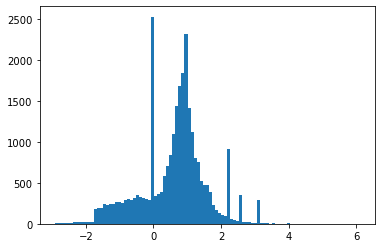

In [7]:
# check a sample
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [8]:
# for simplicity, use first 1000 samples as validation, then 10000 samples as training
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [9]:
# cache() so doesn't need to re-read data on each epoch
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [10]:
# create into batches
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE) # need to shuffle and repeat training set

# Training functions

In [11]:
# models usually train better if decrease learning rate over time
# this sets a hyperbolically decrease that is 1/2 at 1000 epochs, 1/3 at 3000 epochs...
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

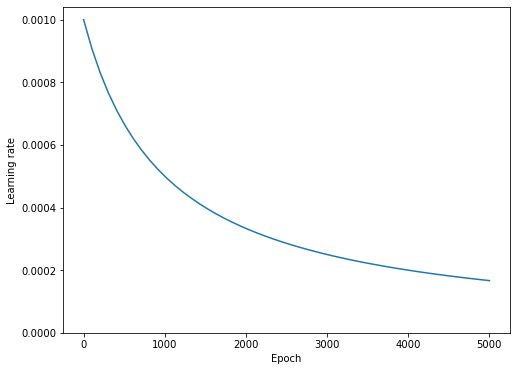

In [12]:
# plot the learning rate decay
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning rate')

In [13]:
# will train many models, define the same callbacks for the training
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(), # only print a . for each epoch, to reduce logging noise
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200), # monitors binary_crossentropy, not loss, because later regularization component is mixed in loss but not binary_crossentropy
        tf.keras.callbacks.TensorBoard(logdir/name)
    ]

In [14]:
# will train many models, define a function for the same compile and fit settings
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), 'accuracy']
    )

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0
    )

    return history

# Overfitting

In [15]:
# start with a tiny model
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES, )),
    layers.Dense(1)
])

In [16]:
# dictionary to keep history of all models
size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch: 0, accuracy:0.4745,  binary_crossentropy:0.8510,  loss:0.8510,  val_accuracy:0.4850,  val_binary_crossentropy:0.7616,  val_loss:0.7616,  
....................................................................................................
Epoch: 100, accuracy:0.5959,  binary_crossentropy:0.6262,  loss:0.6262,  val_accuracy:0.5850,  val_binary_crossentropy:0.6275,  val_loss:0.6275,  
......................................................

(0.5, 0.7)

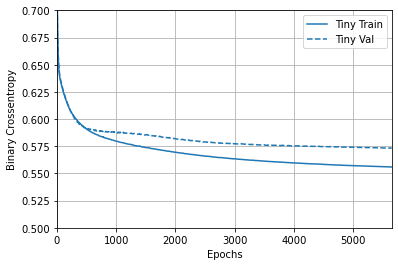

In [17]:
# plot model
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [18]:
# try add one more layer
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES, )), # input_shape is only required for .summary()
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4834,  binary_crossentropy:0.7752,  loss:0.7752,  val_accuracy:0.5050,  val_binary_crossentropy:0.7306,  val_loss:0.7306,  
....................................................................................................
Epoch: 100, accuracy:0.6092,  binary_crossentropy:0.6225,  loss:0.6225,  val_accuracy:0.5710,  val_binary_crossentropy:0.6278,  val_loss:0.

In [19]:
# making model larger trained and overfitted muach faster
# try a medium model now
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES, )), # input_shape is only required for .summary()
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5068,  binary_crossentropy:0.6945,  loss:0.6945,  val_accuracy:0.4670,  val_binary_crossentropy:0.6850,  val_loss:0.6850,  
....................................................................................................
E

In [20]:
# try a large model now
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES, )), # input_shape is only required for .summary()
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

size_histories['Large'] = compile_and_fit(medium_model, 'sizes/Large')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.8040,  binary_crossentropy:0.3941,  loss:0.3941,  val_accuracy:0.6570,  val_binary_crossentropy:0.7331,  val_loss:0.7331,  
....................................................................................................
E

Text(0.5, 0, 'Epochs [Log Scale]')

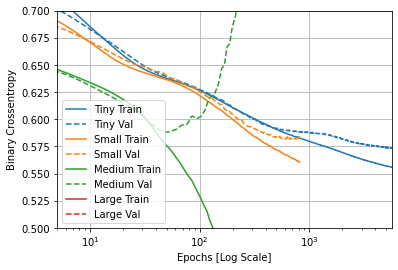

In [21]:
# plot train and val loss for all models to compare overfitting
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

# Regularization

In [22]:
# copy the log of Tiny model to use as a baseline
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/kevin/AppData/Local/Temp/tmp6hz0z9qn/tensorboard_logs/regularizers/Tiny')

In [23]:
# dictionary to keep history of all models after regularization
regularizer_histories = {}

# no reguarlizing the tiny model
regularizer_histories['Tiny'] = size_histories['Tiny']

### Weight regularization

In [24]:
# L2 regularization is more common than L1, because it doesn't cause sparse models
# add l2 regularizer to the large model, every coefficient in the weight matrix will add 0.001 * weight_coefficient_value * 2 to total loss of model
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES, )),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5010,  binary_crossentropy:0.7641,  loss:2.2712,  val_accuracy:0.4780,  val_binary_crossentr

(0.5, 0.7)

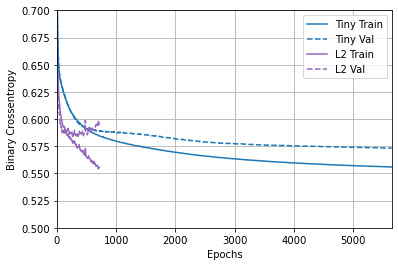

In [25]:
# plot it
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

### Dropout

In [26]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES, )),
    layers.Dropout(0.5), # usually between 0.2 to 0.5
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

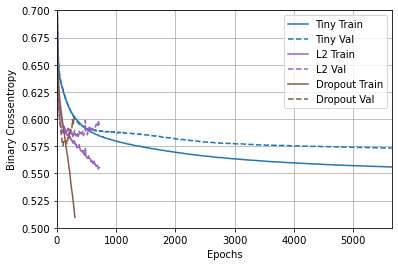

In [27]:
# plot it
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [28]:
# individually, l2 or dropout was not better than tiny, try combining them
combined_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES, )),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, 'regularizers/combined')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

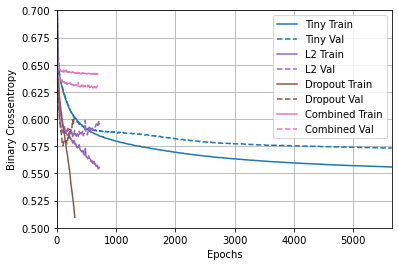

In [29]:
# plot it
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])